In [1]:
import matplotlib.pyplot as plt
import numpy as np
# from shapely.geometry import LineString,Point, Polygon, shape
# from shapely.ops import unary_union
# import geopandas as gpd
import pandas as pd
import os
from tqdm import tqdm
import dpkt

from LiDARBase import *
from Utils import *
from GenBckFile import *
# use sobel filter to get horizontal gradient
from scipy import ndimage
from scipy.signal import convolve2d
from DDBSCAN import *
import matplotlib.colors as mcolors


pygame 2.6.0 (SDL 2.28.4, Python 3.8.19)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
# unix time to utc time to pacific time
def unix2utc(unix_time):
    return pd.to_datetime(unix_time,unit='s').tz_localize('UTC').tz_convert('US/Pacific')
def load_pcap(file_path):
    try:
        fpcap = open(file_path, 'rb')
        eth_reader = dpkt.pcap.Reader(fpcap)
    except Exception as ex:
        print(str(ex))
        return None
    return eth_reader
    
def read_packets_offline(pcap_file_path):
    eth_reader = load_pcap(pcap_file_path)
    while True:
        # Simulate reading a packet from the Ethernet
        try:
            ts,buf = next(eth_reader)
        except StopIteration:
            return None
        eth = dpkt.ethernet.Ethernet(buf)
        if eth.type == 2048: # for ipv4
            if (type(eth.data.data) == dpkt.udp.UDP):# for ipv4
                data = eth.data.data.data
                packet_status = eth.data.data.sport
                if packet_status == 2368:
                    if len(data) != 1206:
                        continue
            # raw_packet = np.random.rand(20000,2) * 600  # Placeholder for actual packet data
                    yield (ts,data)
                    
def parse_packets(packet_gen):
    
    culmulative_azimuth_values = []
    culmulative_laser_ids = []
    culmulative_distances = []
    # culmulative_intensities = []
    Td_map = np.zeros((32,1800))
    # Intens_map = np.zeros((32,1800))
    next_ts = 0
    packet = next(packet_gen)
    if packet is None:
        return None
    ts,raw_packet = packet
    distances,intensities,azimuth_per_block,Timestamp = parse_one_packet(raw_packet)
    next_ts = ts + 0.1 # 0.1sec
    azimuth = calc_precise_azimuth(azimuth_per_block) # 32 x 12
    culmulative_azimuth_values.append(azimuth)
    culmulative_laser_ids.append(laser_id)
    culmulative_distances.append(distances)
            
    break_flag = False
    while True:
        if break_flag:
            break  
        while True:
            try:
                packet = next(packet_gen)
            except StopIteration:
                break_flag = True
                break
            ts,raw_packet = packet
            # Placeholder for parsing logic; here we just pass the data through
            distances,intensities,azimuth_per_block,Timestamp = parse_one_packet(raw_packet)
            # flag = self.if_rollover(azimuth_per_block,Initial_azimuth)
            azimuth = calc_precise_azimuth(azimuth_per_block) # 32 x 12
            
            if ts > next_ts:
                
                if len(culmulative_azimuth_values) > 0:
                    
                    culmulative_azimuth_values = np.concatenate(culmulative_azimuth_values,axis = 1)
                    culmulative_azimuth_values += Data_order[:,1].reshape(-1,1)
                    culmulative_laser_ids = np.concatenate(culmulative_laser_ids,axis = 1).flatten()
                    culmulative_distances = np.concatenate(culmulative_distances,axis = 1).flatten()
                    # culmulative_intensities = np.concatenate(culmulative_intensities,axis = 1).flatten()
                    culmulative_azimuth_inds = np.around(culmulative_azimuth_values/0.2).astype('int').flatten()
                    culmulative_azimuth_inds[(culmulative_azimuth_inds<0)|(culmulative_azimuth_inds>1799)] = culmulative_azimuth_inds[(culmulative_azimuth_inds<0)|(culmulative_azimuth_inds>1799)]%1799

                    Td_map[culmulative_laser_ids,culmulative_azimuth_inds] = culmulative_distances
                    # Intens_map[culmulative_laser_ids,culmulative_azimuth_inds] = culmulative_intensities
                    
                    yield Td_map[arg_omega,:] #32*1800
                else:
                    yield Td_map,ts #32*1800

                culmulative_azimuth_values = []
                culmulative_laser_ids = []
                culmulative_distances = []
                # culmulative_intensities = []

                Td_map = np.zeros((32,1800))
                # Intens_map = np.zeros((32,1800))
                next_ts += 0.1
                break
            else:
                culmulative_azimuth_values.append(azimuth)
                culmulative_laser_ids.append(laser_id)
                culmulative_distances.append(distances)
                # culmulative_intensities.append(intensities)
    return None

In [3]:
Td_maps = []
pcap_file_path = r'D:\LiDAR_Data\9thVir\2024-03-14-23-30-00.pcap'
packets_gen = read_packets_offline(pcap_file_path)
packet = next(packets_gen)
Initial_ts,raw_packet = packet

packets_gen = read_packets_offline(pcap_file_path)
td_gen = parse_packets(packets_gen)
point_nums = []
for Td_map in tqdm(td_gen):
    point_nums.append((Td_map > 0.1).sum())
    Td_maps.append(Td_map)
bck_radius = 0.3
vertical_limits = [0,31]
lane_drawer = LaneDrawer() # lane drawer for queue detection
lane_drawer.update_lane_gdf()
lane_gdf = lane_drawer.lane_gdf
Td_maps = np.array(Td_maps)

# total_dis = []
# for i in tqdm(range(len(Td_maps))):
#     Td_map = Td_maps[i]
#     total_dis.append(Td_map.sum())

# total_dis = np.array(total_dis)
# mean_dis = total_dis.mean()
thred_map = gen_bckmap(Td_maps, N = 10,d_thred = 0.1,bck_n = 3)   
np.save('./thred_map.npy',thred_map)
thred_map = np.load('./thred_map.npy')

17989it [06:22, 47.06it/s]


Lane zone updated


In [32]:
thred_map = gen_bckmap(np.array(Td_maps), N = 10,d_thred = 0.1,bck_n = 3)   
foreground_point_num = []
total_dis = []
for i in tqdm(range(len(Td_maps))):
    Td_map = Td_maps[i]
    Foreground_map = ~(np.abs(Td_map - thred_map) <= bck_radius).any(axis = 0)
    Foreground_map = Foreground_map.astype(int)
    foreground_point_num.append(Foreground_map.sum())
    total_dis.append(Td_map.sum())
foreground_point_num = np.array(foreground_point_num)
total_dis = np.array(total_dis)
mean_dis = total_dis.mean()
# extract the frames that have more points than the mean + 2 std


100%|██████████| 17989/17989 [00:12<00:00, 1433.71it/s]


In [4]:
# create lane_unit_range_ranging_Tdmap
lane_unit_range_ranging_Tdmap = []
for unit_ind in range(len(lane_gdf)):
    lane_unit = lane_gdf.iloc[unit_ind]
    x_coords,y_coords = lane_unit.geometry.exterior.coords.xy
    coords = np.c_[x_coords,y_coords]
    
    azimuth_unit = np.arctan2(coords[:,0],coords[:,1]) * 180 / np.pi
    azimuth_unit[azimuth_unit < 0] += 360
    min_azimuth = np.min(azimuth_unit)
    max_azimuth = np.max(azimuth_unit)
    min_ind = int(min_azimuth / 0.2)
    max_ind = int(max_azimuth / 0.2)

    dis = np.sum(coords**2,axis = 1)**0.5
    min_dis = np.min(dis)
    max_dis = np.max(dis)
    lane_unit_range_ranging_Tdmap.append([min_ind,max_ind,min_dis,max_dis])


In [5]:
def get_occupation_ind(Td_map,lane_unit_range_ranging_Tdmap,count_thred):
    Foreground_map = ~(np.abs(Td_map - thred_map) <= bck_radius).any(axis = 0)
    Foreground_map = Foreground_map.astype(int)
    Td_map_cos = np.cos(theta * np.pi/180).reshape(-1,1) * Td_map
    occupation_ind = []
    for min_ind,max_ind,min_dis,max_dis in lane_unit_range_ranging_Tdmap:
        if max_ind - min_ind > 900:
            occupation_map = np.concatenate([Foreground_map[:,:min_ind],Foreground_map[:,max_ind:]],axis = 1)
            dis_map = np.concatenate([Td_map_cos[:,:min_ind],Td_map_cos[:,max_ind:]],axis = 1)
        else:
            occupation_map = Foreground_map[:,min_ind:max_ind]
            dis_map = Td_map_cos[:,min_ind:max_ind]
        
        dis_map_ = dis_map * occupation_map
        occupation_flag = ((dis_map_ < max_dis) * (dis_map_ > min_dis)).sum() > count_thred
        occupation_ind.append(occupation_flag)
    occupation_ind = np.array(occupation_ind)
    return occupation_ind

In [6]:
Td_map = Td_maps[0]
occupation_ind = get_occupation_ind(Td_maps[0],lane_unit_range_ranging_Tdmap,5)

In [7]:
data_raw,point_labels,tracking_dic = get_foreground_point_cloud(thred_map,bck_radius,
                                                                        Td_map,vertical_limits)
foreground_point = data_raw[point_labels == 1]
lane_section_foreground_point_counts = get_lane_section_foreground_point_counts(lane_drawer.lane_subsections_poly,
                                                                            lane_drawer.lane_gdf,
                                                                            data_raw,point_labels)

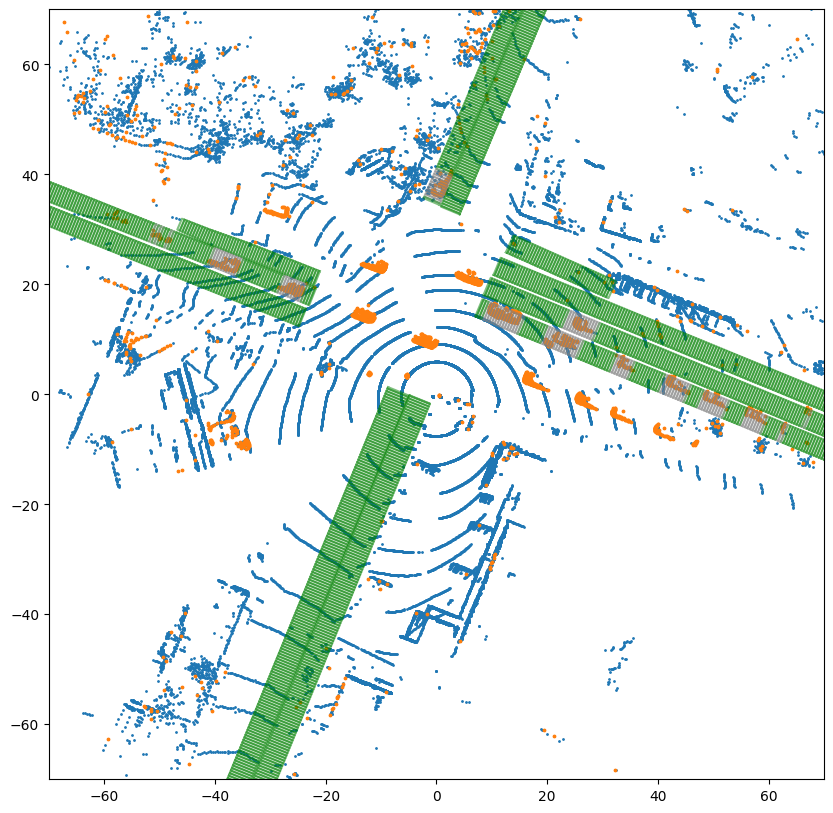

In [8]:
# plot lane_gdf, if cooresponding unit is occupied (True in occupation_ind), plot it in red, otherwise in green, also plot the foreground point cloud (data_raw)
fig,ax = plt.subplots(figsize = (10,10))
for unit_ind in range(len(lane_gdf)):
    lane_unit = lane_gdf.iloc[unit_ind]
    x_coords,y_coords = lane_unit.geometry.exterior.coords.xy
    coords = np.c_[x_coords,y_coords]
    if occupation_ind[unit_ind]:
        ax.plot(coords[:,0],coords[:,1],color = 'gray',alpha = 0.5)
    else:
        ax.plot(coords[:,0],coords[:,1],color = 'g',alpha = 0.5)
ax.scatter(data_raw[:,0],data_raw[:,1],s = 1)
ax.scatter(foreground_point[:,0],foreground_point[:,1],s = 3)
plt.xlim(-70,70)
plt.ylim(-70,70)
plt.show()

In [9]:
count_thred = 5
time_space_series = [] # t x laen# x lane_section#
for Td_map in tqdm(Td_maps):
    activation_profile = []
    occupation_ind = get_occupation_ind(Td_map,lane_unit_range_ranging_Tdmap,count_thred)
    data_raw,point_labels,tracking_dic = get_foreground_point_cloud(thred_map,bck_radius,
                                                                        Td_map,vertical_limits)
    for lane_id,g in lane_gdf.groupby('lane_id'):
        activation_profile.append(occupation_ind[g.index])
    time_space_series.append(activation_profile)

100%|██████████| 17989/17989 [07:07<00:00, 42.10it/s]


In [8]:
"""
Old Version
"""
count_thred = 3
time_space_series = [] # t x laen# x lane_section#
for Td_map in tqdm(Td_maps):
    
    data_raw,point_labels,tracking_dic = get_foreground_point_cloud(thred_map,bck_radius,
                                                                            Td_map,vertical_limits)
    if len(data_raw) == 0:
        break
    lane_section_foreground_point_counts = get_lane_section_foreground_point_counts(lane_drawer.lane_subsections_poly,
                                                                                lane_drawer.lane_gdf,
                                                                                data_raw,point_labels)
    activation_profile = []
    for lane_counts in lane_section_foreground_point_counts:
        occupation = np.array(lane_counts) > count_thred
        activation_profile.append(occupation)
    time_space_series.append(activation_profile)
# test_time_space_series = np.array(test_time_space_series)

  0%|          | 0/17989 [00:00<?, ?it/s]

100%|██████████| 17989/17989 [11:41<00:00, 25.65it/s]


In [10]:
lane_ind = 0
lane_activation_profile = []
for t in range(len(time_space_series)):
    lane_activation_cur = time_space_series[t][lane_ind]
    lane_activation_profile.append(lane_activation_cur)
lane_activation_profile = np.array(lane_activation_profile,dtype=int)
lane_activation_profile_T = lane_activation_profile.T

In [11]:
lane_activation_profile_T = lane_activation_profile.T
stop_specturm = ndimage.sobel(lane_activation_profile_T, 0,mode='reflect')  # horizontal gradient
traveling_specturm = ndimage.sobel(lane_activation_profile_T, 1,mode='reflect')  # vertical gradient

In [121]:
db = Raster_DBSCAN(Td_map_szie=lane_activation_profile_T.shape, window_size=[7,21],eps = 1,min_samples=4)
Labels = db.fit_predict(lane_activation_profile_T,Foreground_map=lane_activation_profile_T == 1)

In [102]:
unique_labels,inverse_ind = np.unique(Labels,return_inverse=True,axis = 1)

In [120]:
import numpy as np
from sklearn.cluster._dbscan_inner import dbscan_inner
from numpy.lib.stride_tricks import sliding_window_view

class Raster_DBSCAN():
    def __init__(self,window_size,eps,min_samples,Td_map_szie):
        """
        This method applys the vectorization calculation, 
        where the TD map is chunked as multiple parts and corresponding neighbors in each center of chunk are counted and recorded.
        The calculated neighbors are stored in the neighborhood list which is then treated as an input for the dbscan_inner() so as to
        utilize the core CPP API from the sklearn. 

        *** 
        Step.1 -> Seperate output chunks including Td_map, Index_map, Foreground_map
        Step.2 -> Neigborhoods calculation
        Step.3 -> dbscan_inner()
        """
        self.window_size = window_size #(height,width)
        self.Td_map_size = Td_map_szie
        self.eps = eps
        self.min_samples = min_samples
        self.Height_fringe = int(self.window_size[0]/2) 
        self.Width_fringe = int(self.window_size[1]/2) # azimuth
        self.Td_map = None #Two-Dimentional Map   
        self.Foreground_map = None # A mask  indicating those pixels are required to be clustered
        self.Labeling_map_template = -1*np.ones(Td_map_szie,dtype = np.int64)
        self.Index_map = None # an intermediate variable
        self.Height_fringe_offset_fore = np.full((self.Height_fringe,Td_map_szie[1] + 2 * self.Width_fringe),False) 
        self.Height_fringe_offset_td = np.full((self.Height_fringe,Td_map_szie[1] + 2 * self.Width_fringe),200) 
        self.Heigh_fringe_offset_index = np.full((self.Height_fringe,Td_map_szie[1] + 2 * self.Width_fringe),-1,dtype = np.int64) 

        
        
    def fit_predict(self,Td_map,Foreground_map):
        
        self.Td_map = Td_map
        self.Foreground_map = Foreground_map

        rows,cols = np.where(Foreground_map)
        indices = np.arange(len(rows),dtype = np.int64)
        self.Index_map = -1 * np.ones(shape = Foreground_map.shape,dtype=np.int64)
        self.Index_map[rows,cols] = indices # A map with the index of foreground point 
        
        # Horizontal padding
        
        Foreground_map_offset = np.concatenate([np.full((self.Foreground_map.shape[0],self.Width_fringe),False),
                                                self.Foreground_map,
                                                np.full((self.Foreground_map.shape[0],self.Width_fringe),False)],axis = 1)
        Index_map_offset = np.concatenate([np.full((self.Index_map.shape[0],self.Width_fringe),-1,dtype = np.int64),
                                        self.Index_map,
                                        np.full((self.Index_map.shape[0],self.Width_fringe),-1,dtype = np.int64)],axis = 1)
        Td_map_offset = np.concatenate([np.full((self.Td_map.shape[0],self.Width_fringe),200),
                                        self.Td_map,
                                        np.full((self.Td_map.shape[0],self.Width_fringe),200)],axis = 1)

        # Vertical padding 
        Foreground_map_offset = np.concatenate([self.Height_fringe_offset_fore,
                                                Foreground_map_offset,
                                            self.Height_fringe_offset_fore])
        Index_map_offset = np.concatenate([self.Heigh_fringe_offset_index,
                                        Index_map_offset,
                                        self.Heigh_fringe_offset_index])
        Td_map_offset = np.concatenate([self.Height_fringe_offset_td,
                                    Td_map_offset,
                                    self.Height_fringe_offset_td])
        
        Sub_indmap = sliding_window_view(Index_map_offset,self.window_size).reshape(-1,self.window_size[0],self.window_size[1])
        Sub_tdmap = sliding_window_view(Td_map_offset,self.window_size).reshape(-1,self.window_size[0],self.window_size[1])
        Sub_foremap = sliding_window_view(Foreground_map_offset,self.window_size).reshape(-1,self.window_size[0],self.window_size[1])

        # Window inds that are valid as Foregound, and only 
        # self.Sub_foremap,self.Sub_indmap,self.Sub_tdmap = Sub_foremap,Sub_indmap,Sub_tdmap
        valid_windows = Sub_foremap[:,self.Height_fringe ,self.Width_fringe] 
        # self.valid_windows = valid_windows
        Sub_indmap,Sub_foremap,Sub_tdmap = Sub_indmap[valid_windows],Sub_foremap[valid_windows],Sub_tdmap[valid_windows]
        
        # ***key step
        center_td_dist = Sub_tdmap[:,self.Height_fringe,self.Width_fringe]
        temp = ((np.abs((Sub_tdmap - center_td_dist.reshape(-1,1,1))) < self.eps) & Sub_foremap)
        neighborhoods = np.array([Sub_indmap[i][temp[i]] for i in range(len(temp))],dtype = 'O')
        n_neighbors = np.array([len(neighbor) for neighbor in neighborhoods])
        Labels = np.full(len(n_neighbors), -1, dtype=np.intp)
        core_samples = np.asarray(n_neighbors >= self.min_samples,dtype=np.uint8)
        
        try:
            dbscan_inner(core_samples, neighborhoods, Labels)
        except:
            pass

        Labeling_map = self.Labeling_map_template.copy()

        Labeling_map[rows,cols] = Labels
        # self.Labeling_map = Labeling_map
        
        return Labeling_map


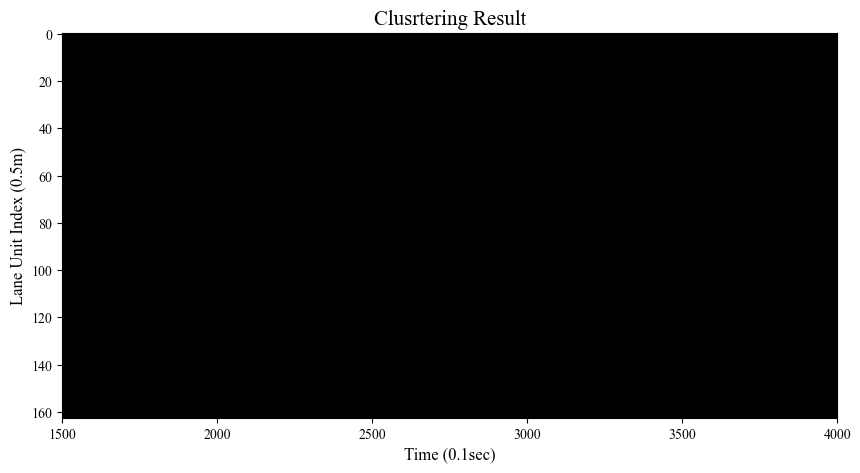

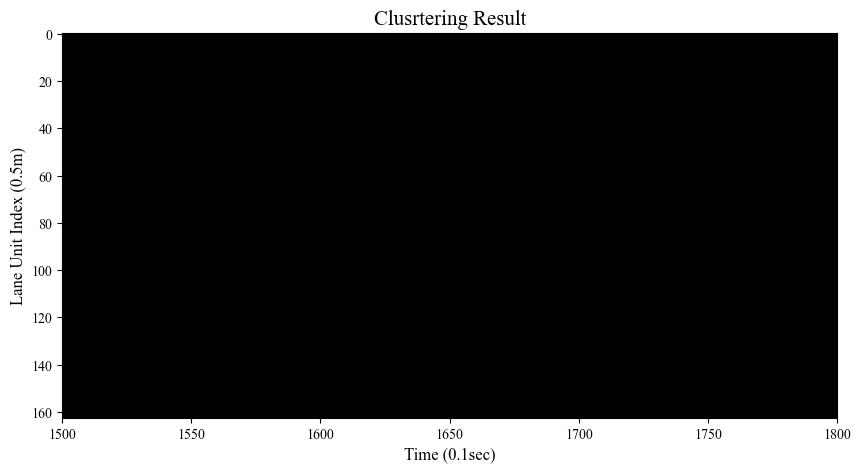

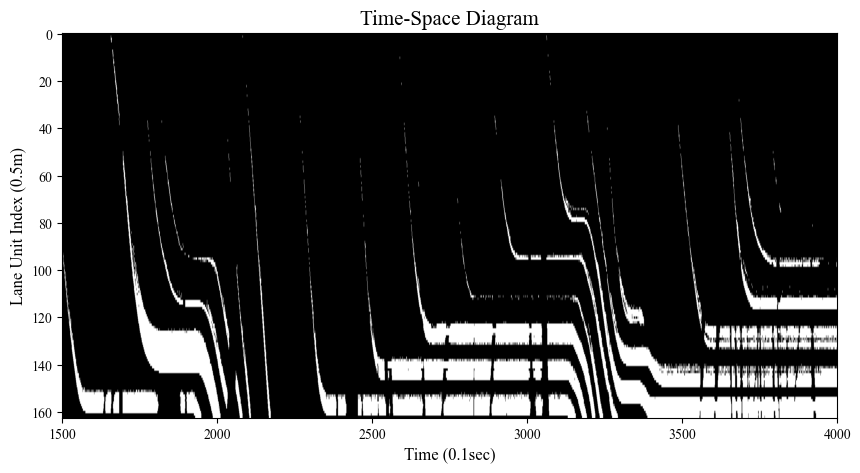

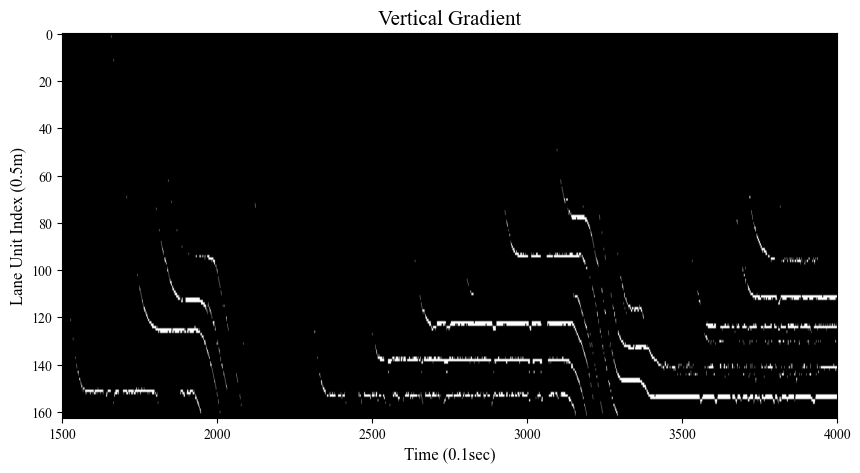

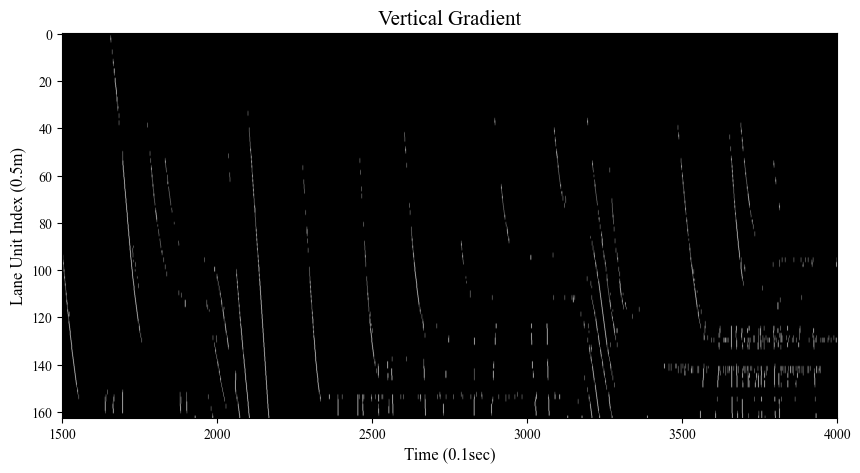

In [115]:
seed = 414
np.random.seed(seed)
colors = np.random.rand(600, 3)
colors = np.concatenate([np.array([[0,0,0]]),colors],axis = 0)
colormap = mcolors.ListedColormap(colors)

plt.rc('font', family='times new roman')
plt.figure(figsize=(10,5))
plt.title('Clusrtering Result',fontsize = 15)
plt.imshow(Labels,aspect='auto', cmap=colormap, interpolation='none')
plt.xlim(1500,4000)
plt.xlabel('Time (0.1sec)',fontsize = 12)
plt.ylabel('Lane Unit Index (0.5m)',fontsize = 12)
plt.show()

plt.rc('font', family='times new roman')
plt.figure(figsize=(10,5))
plt.title('Clusrtering Result',fontsize = 15)
plt.imshow(Labels,aspect='auto', cmap=colormap, interpolation='none')
plt.xlim(1500,1800)
plt.xlabel('Time (0.1sec)',fontsize = 12)
plt.ylabel('Lane Unit Index (0.5m)',fontsize = 12)
plt.show()

plt.figure(figsize=(10,5))
plt.title('Time-Space Diagram',fontsize = 15)
plt.imshow(lane_activation_profile_T,aspect='auto', cmap='gray')
plt.xlim(1500,4000)
plt.xlabel('Time (0.1sec)',fontsize = 12)
plt.ylabel('Lane Unit Index (0.5m)',fontsize = 12)
plt.show()

plt.figure(figsize=(10,5))
plt.title('Vertical Gradient',fontsize = 15)
plt.imshow(stop_specturm > 3,aspect='auto', cmap='gray')
plt.xlim(1500,4000)
plt.xlabel('Time (0.1sec)',fontsize = 12)
plt.ylabel('Lane Unit Index (0.5m)',fontsize = 12)
plt.show()
plt.figure(figsize=(10,5))
plt.title('Vertical Gradient',fontsize = 15)
plt.imshow(traveling_specturm > 2,aspect='auto', cmap='gray')
plt.xlim(1500,4000)
plt.xlabel('Time (0.1sec)',fontsize = 12)
plt.ylabel('Lane Unit Index (0.5m)',fontsize = 12)
plt.show()


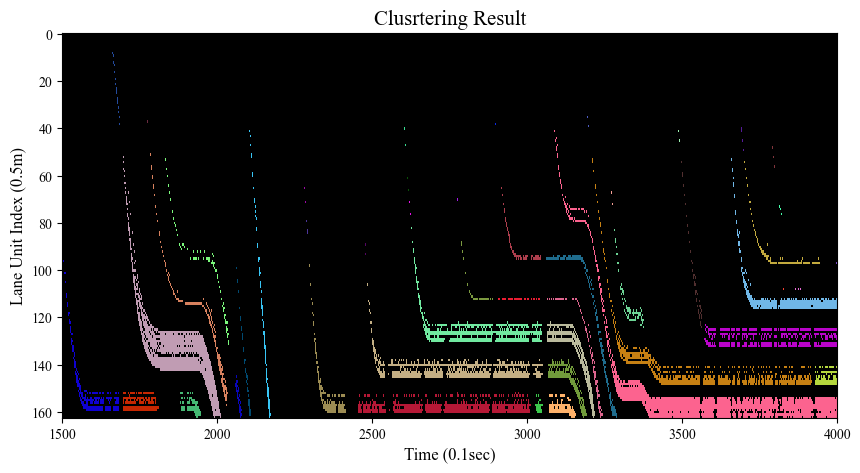

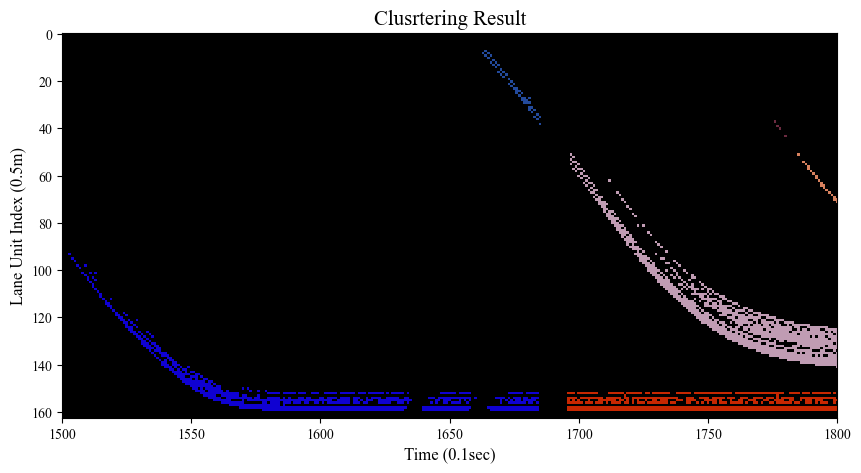

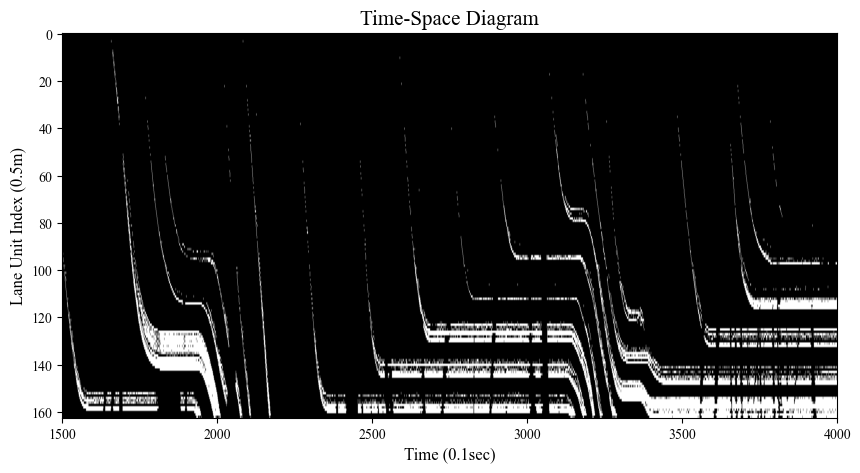

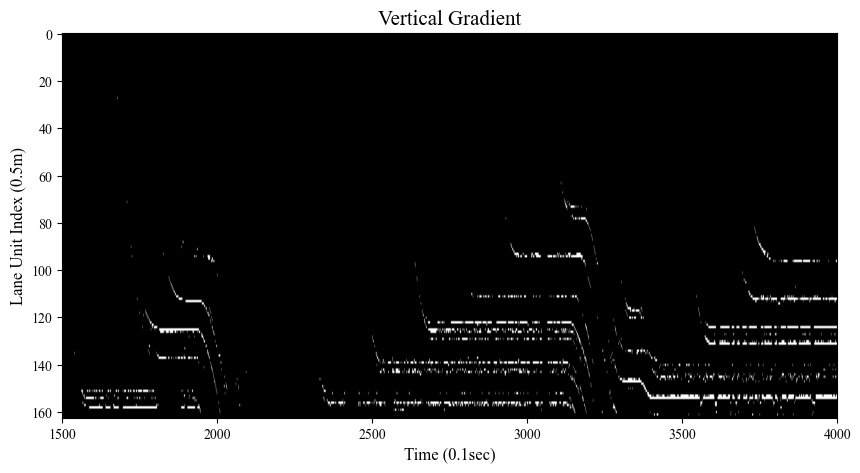

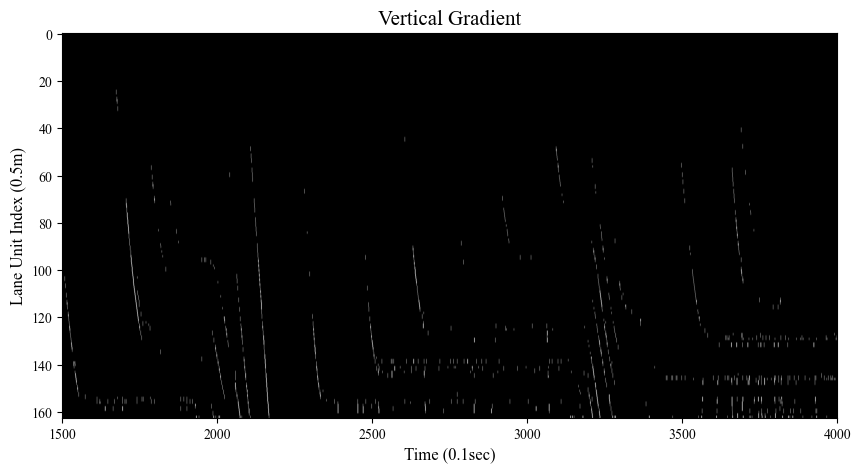

In [127]:
seed = 414
np.random.seed(seed)
colors = np.random.rand(600, 3)
colors = np.concatenate([np.array([[0,0,0]]),colors],axis = 0)
colormap = mcolors.ListedColormap(colors)

plt.rc('font', family='times new roman')
plt.figure(figsize=(10,5))
plt.title('Clusrtering Result',fontsize = 15)
plt.imshow(Labels,aspect='auto', cmap=colormap, interpolation='none')
plt.xlim(1500,4000)
plt.xlabel('Time (0.1sec)',fontsize = 12)
plt.ylabel('Lane Unit Index (0.5m)',fontsize = 12)
plt.show()

plt.rc('font', family='times new roman')
plt.figure(figsize=(10,5))
plt.title('Clusrtering Result',fontsize = 15)
plt.imshow(Labels,aspect='auto', cmap=colormap, interpolation='none')
plt.xlim(1500,1800)
plt.xlabel('Time (0.1sec)',fontsize = 12)
plt.ylabel('Lane Unit Index (0.5m)',fontsize = 12)
plt.show()

plt.figure(figsize=(10,5))
plt.title('Time-Space Diagram',fontsize = 15)
plt.imshow(lane_activation_profile_T,aspect='auto', cmap='gray')
plt.xlim(1500,4000)
plt.xlabel('Time (0.1sec)',fontsize = 12)
plt.ylabel('Lane Unit Index (0.5m)',fontsize = 12)
plt.show()

plt.figure(figsize=(10,5))
plt.title('Vertical Gradient',fontsize = 15)
plt.imshow(stop_specturm > 3,aspect='auto', cmap='gray')
plt.xlim(1500,4000)
plt.xlabel('Time (0.1sec)',fontsize = 12)
plt.ylabel('Lane Unit Index (0.5m)',fontsize = 12)
plt.show()
plt.figure(figsize=(10,5))
plt.title('Vertical Gradient',fontsize = 15)
plt.imshow(traveling_specturm > 2,aspect='auto', cmap='gray')
plt.xlim(1500,4000)
plt.xlabel('Time (0.1sec)',fontsize = 12)
plt.ylabel('Lane Unit Index (0.5m)',fontsize = 12)
plt.show()


In [ ]:
Labels = db.fit_predict(lane_activation_profile_T,Foreground_map=lane_activation_profile_T == 1)
unique_labels = np.unique(Labels)
start_points = []
end_points = []
for label in unique_labels:
    if label == -1:
        continue
    row_inds,col_inds = np.where(Labels == label)
    start_points.append([row_inds[0],col_inds[0]])
    end_points.append([row_inds[-1],col_inds[-1]])
start_points = np.array(start_points)
end_points = np.array(end_points)


In [13]:
queue_length_indicator = empty_specturm != 0

total_queue_length_curve = []
for i in range(0,queue_length_indicator.shape[1],1):
    stops = np.where(queue_length_indicator[:,i])[0]
    if len(stops) == 0:
        total_queue_length_curve.append(0)
        continue
    queue_length_t = (queue_length_indicator.shape[0] - stops.min()) * 0.5
    total_queue_length_curve.append(queue_length_t)
total_queue_length_curve = np.array(total_queue_length_curve)
# sample at 10 frames
total_queue_length_curve_sec = total_queue_length_curve[::10]

In [16]:
# find the start and end of each consecutive activation event
def find_concecutive_activation(activation):
    activation_start = []
    activation_end = []
    activation_flag = False
    for i in range(len(activation)):

        if activation[i] == True and activation_flag == False:
            activation_start.append(i)
            activation_flag = True
        elif activation[i] == False and activation_flag == True:
            activation_end.append(i)
            activation_flag = False
    return activation_start,activation_end

In [18]:
# define a kernal to identify a sudden change toward upper direction
import statistics
kernal = np.array([0] * 10 + [1] * 5)
volumes = []
for i in range(1,10):
    activation = lane_activation_profile_T[-i,:]
    # convolve the kernal with the lane_activation_profile_T
    convolution = np.convolve(activation,kernal,mode='same')
    passing_incator = convolution > 0
    activation_start,activation_end = find_concecutive_activation(passing_incator)
    # activation_end = np.array(activation_end)
    activation_start = np.array(activation_start)
    volume_section = []
    for ts in range(10,lane_activation_profile_T.shape[1] + 10,10):
        volume_section.append(((activation_start < ts)&(activation_start > ts - 10)).sum())
    volumes.append(volume_section)
volumes = np.array(volumes)
volumes_sec = []
for i in range(volumes.shape[1]):
    volumes_sec.append(statistics.mode(volumes[:,i]))
volumes_sec = np.array(volumes_sec)
    

In [28]:
out_folder = '.\output\\2024-03-14-23-30-00\\'
fig_folder = os.path.join(out_folder,'figures')
if not os.path.exists(fig_folder):
    os.makedirs(fig_folder)

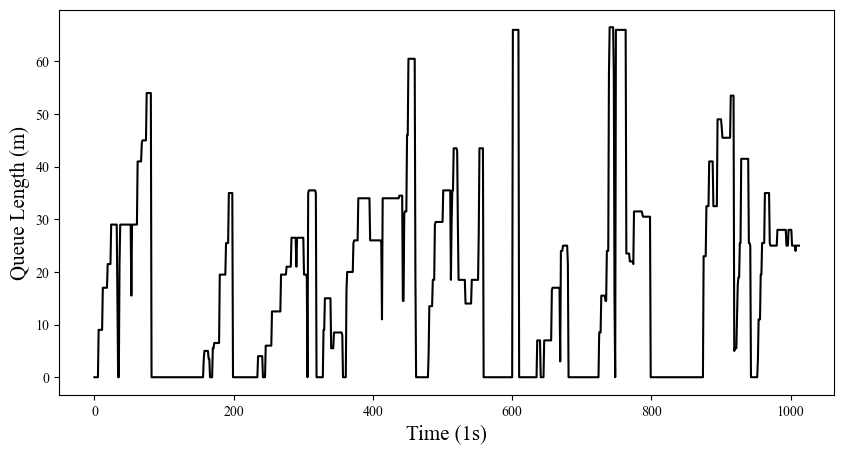

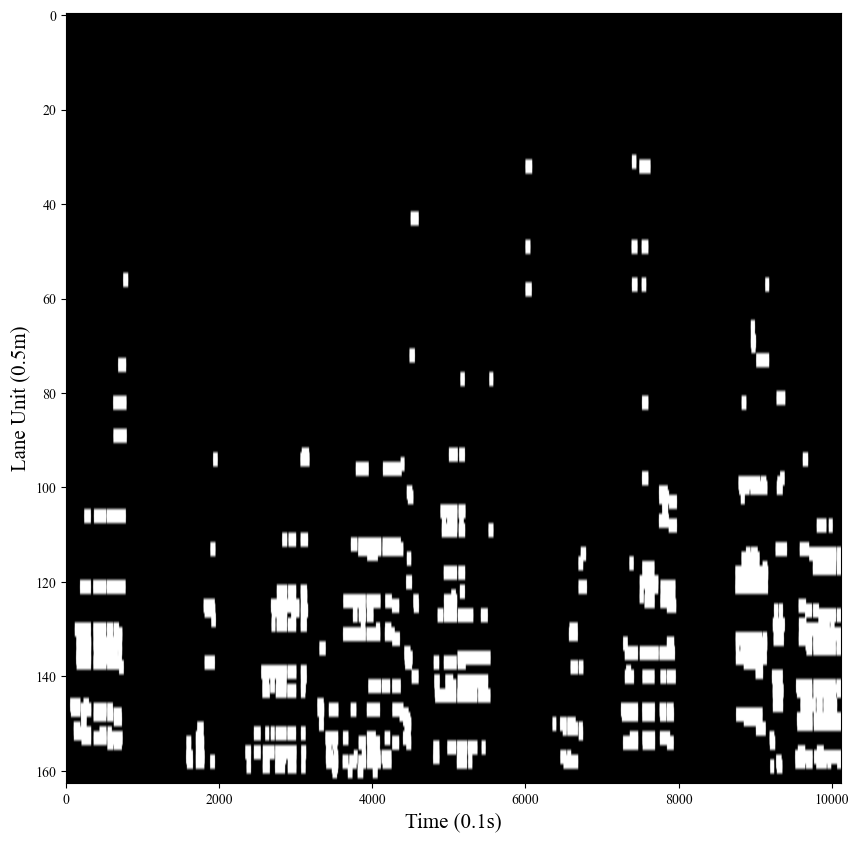

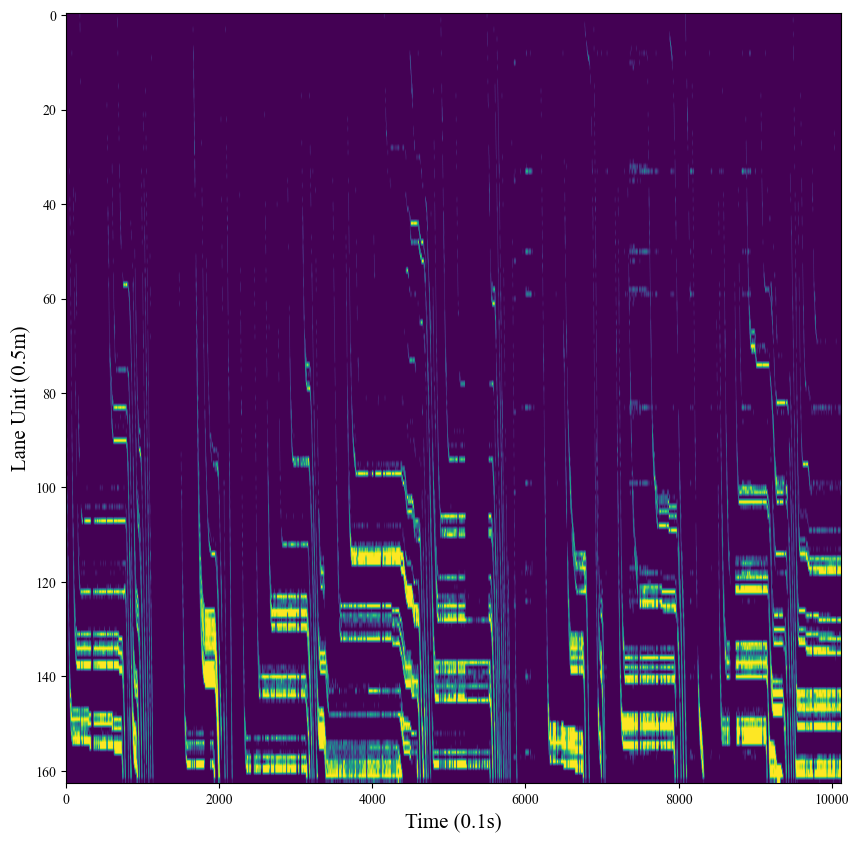

In [30]:
plt.rcParams['font.family'] = 'times new roman'
cum_volumes = []
for i in range(1,volumes_sec.shape[0]):
    cum_volumes.append(volumes_sec[:i].sum())
cum_volumes = np.array(cum_volumes)
plt.figure(figsize = (10,5))
plt.grid()
plt.plot(cum_volumes, linewidth = 2, color = 'black')
plt.xlabel('Time (1s)',fontsize = 15)
plt.ylabel('Volume (veh)',fontsize = 15)
plt.savefig(os.path.join(fig_folder,f'volume_{lane_ind}.png'),dpi = 300)
plt.close()
plt.figure(figsize = (10,5))
plt.plot(total_queue_length_curve_sec, color = 'black')
plt.xlabel('Time (1s)',fontsize = 15)
plt.ylabel('Queue Length (m)',fontsize = 15)
plt.savefig(os.path.join(fig_folder,f'queue_{lane_ind}.png'),dpi = 300)
plt.figure(figsize = (10,10))
# increase distincness of the image
plt.imshow(empty_specturm,aspect = 'auto',cmap='gray',interpolation = None)
# plt.imshow(sobel_v,aspect = 'auto',cmap='gray',interpolation = None)
plt.xlabel('Time (0.1s)',fontsize = 15)
plt.ylabel('Lane Unit (0.5m)',fontsize = 15)
# plt.xlim(14000,15500)# plt.ylim(0,32)
plt.savefig(os.path.join(fig_folder,f'queue_spectrum_{lane_ind}.png'),dpi = 300)
plt.figure(figsize = (10,10))
plt.imshow(lane_activation_profile_T,aspect = 'auto',interpolation = None)
plt.xlabel('Time (0.1s)',fontsize = 15)
plt.ylabel('Lane Unit (0.5m)',fontsize = 15)
# plt.xlim(12000,15500)
plt.savefig(os.path.join(fig_folder,f'time_space_{lane_ind}.png'),dpi = 300)

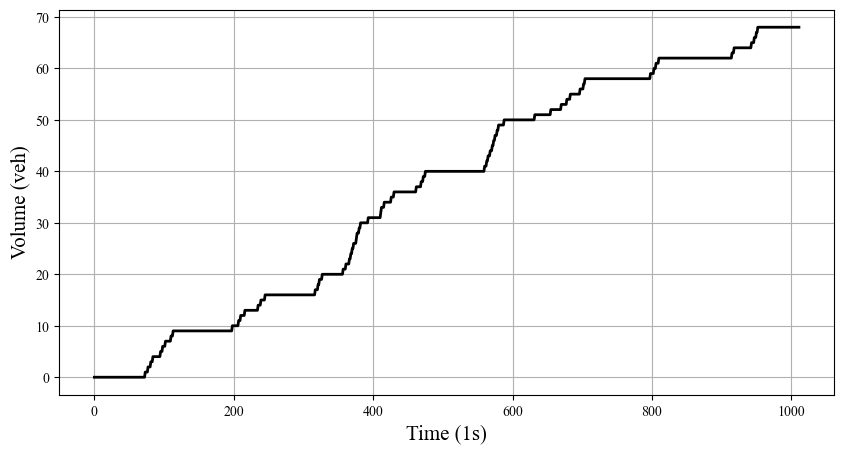

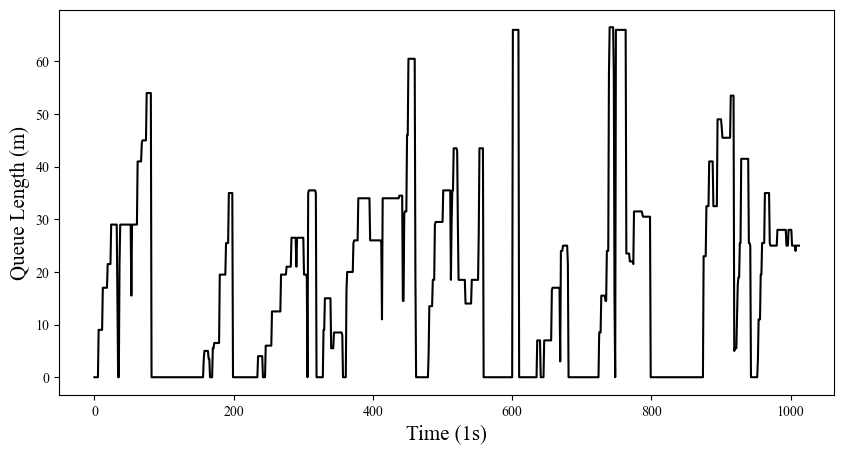

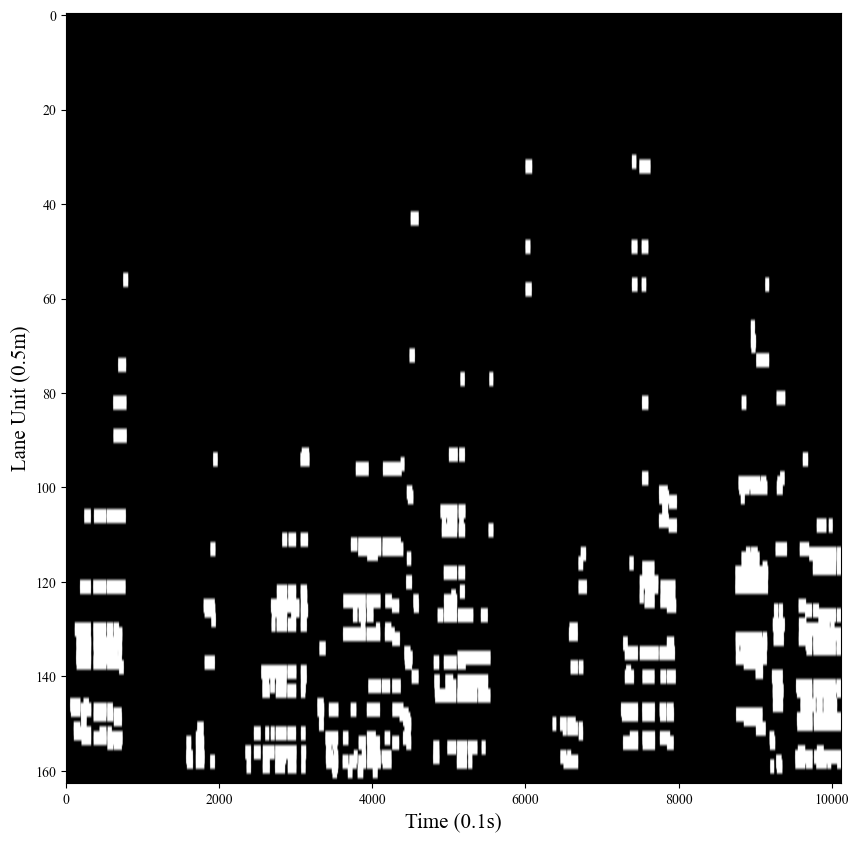

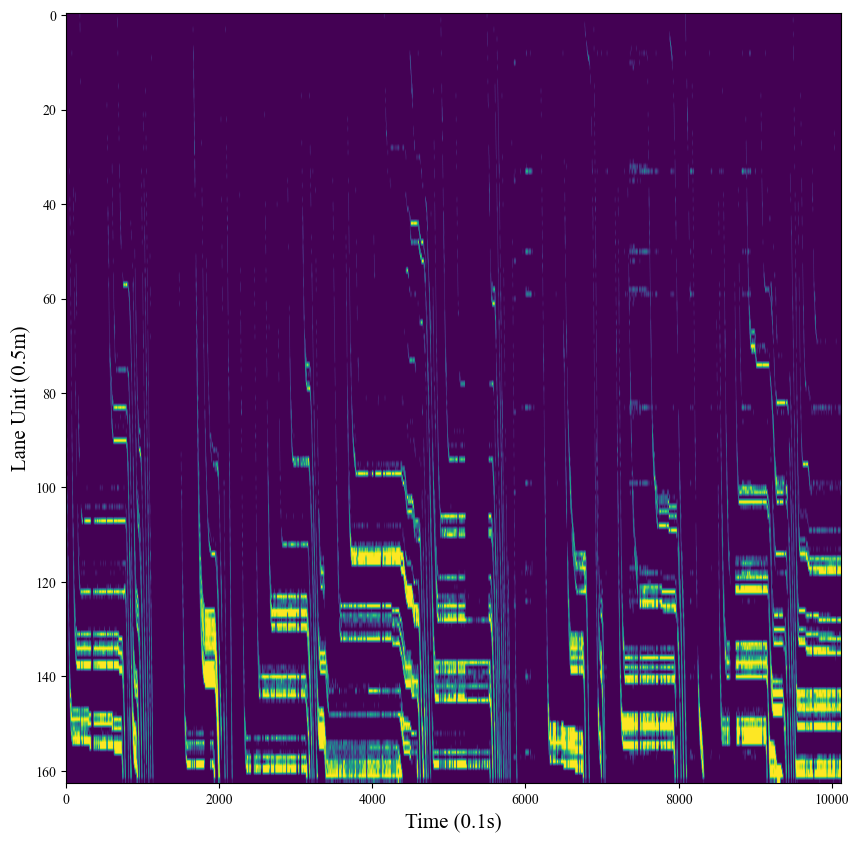

In [19]:
# plot the "cummulative" (sum up the volumes of all previous num) volume curve_sec
# times new roman
plt.rcParams['font.family'] = 'times new roman'
cum_volumes = []
for i in range(1,volumes_sec.shape[0]):
    cum_volumes.append(volumes_sec[:i].sum())
cum_volumes = np.array(cum_volumes)
plt.figure(figsize = (10,5))
plt.grid()
plt.plot(cum_volumes, linewidth = 2, color = 'black')
plt.xlabel('Time (1s)',fontsize = 15)
plt.ylabel('Volume (veh)',fontsize = 15)
plt.show()

plt.figure(figsize = (10,5))

plt.plot(total_queue_length_curve_sec, color = 'black')
plt.xlabel('Time (1s)',fontsize = 15)
plt.ylabel('Queue Length (m)',fontsize = 15)
plt.show()
plt.figure(figsize = (10,10))
# increase distincness of the image
plt.imshow(empty_specturm,aspect = 'auto',cmap='gray',interpolation = None)
# plt.imshow(sobel_v,aspect = 'auto',cmap='gray',interpolation = None)
plt.xlabel('Time (0.1s)',fontsize = 15)
plt.ylabel('Lane Unit (0.5m)',fontsize = 15)
# plt.xlim(14000,15500)# plt.ylim(0,32)
plt.show()
plt.figure(figsize = (10,10))
plt.imshow(lane_activation_profile_T,aspect = 'auto',interpolation = None)
plt.xlabel('Time (0.1s)',fontsize = 15)
plt.ylabel('Lane Unit (0.5m)',fontsize = 15)
# plt.xlim(12000,15500)
plt.show()

## Summary 

In [516]:
count_thred = 3 # activation point cloud # threshold
bck_radius = 0.2
vertical_limits = [0,31]
lane_drawer = LaneDrawer() # lane drawer for queue detection
lane_drawer.update_lane_gdf()


def main(pcap_file_path,lane_drawer,out_path):
    
    # extract the pcap_file name of the pcap_file_path and exclude the .pcap extension
    pcap_file_name = os.path.basename(pcap_file_path).split('.')[0]
    # create a folder to store the output by the pcap_file name and out_path
    out_folder = os.path.join(out_path,pcap_file_name)
    if not os.path.exists(out_folder):
        os.makedirs(out_folder)
    # create a folder in out_folder to store the figures
    fig_folder = os.path.join(out_folder,'figures')
     
    Td_maps = []
    packets_gen = read_packets_offline(pcap_file_path)
    packet = next(packets_gen)
    Initial_ts,raw_packet = packet
    # unix time to utc time to pacific time
    Initial_date = unix2utc(Initial_ts)
    packets_gen = read_packets_offline(pcap_file_path)
    td_gen = parse_packets(packets_gen)
    for Td_map in tqdm(td_gen):
        Td_maps.append(Td_map)
    
    background_data = np.array(Td_maps)
    thred_map = gen_bckmap(np.array(background_data), N = 10,d_thred = 0.1,bck_n = 3)
    # save thred_map as .npy file in out_folder
    np.save(os.path.join(out_folder,'thred_map.npy'),thred_map)
    
    time_space_series = [] # t x laen# x lane_section#
    for Td_map in tqdm(Td_maps):
        data_raw,point_labels,tracking_dic = get_foreground_point_cloud(thred_map,bck_radius,
                                                                                Td_map,vertical_limits)
        if len(data_raw) == 0:
            time_space_series.append(None)
            continue
        lane_section_foreground_point_counts = get_lane_section_foreground_point_counts(lane_drawer.lane_subsections_poly,
                                                                                    lane_drawer.lane_gdf,
                                                                                    data_raw,point_labels)
        activation_profile = []
        for lane_counts in lane_section_foreground_point_counts:
            occupation = np.array(lane_counts) > count_thred
            activation_profile.append(occupation)
        time_space_series.append(activation_profile)
    time_space_series = np.array(time_space_series)


    for lane_ind in range(len(lane_drawer.lane_subsections_poly)):
        lane_activation_profile = []
        for t in range(len(time_space_series)):
            lane_activation_cur = time_space_series[t][lane_ind]
            lane_activation_profile.append(lane_activation_cur)
        lane_activation_profile = np.array(lane_activation_profile,dtype=int)
        lane_activation_profile_T = lane_activation_profile.T
        stop_specturm = ndimage.sobel(lane_activation_profile_T, 0)  # horizontal gradient
        empty_specturm = np.zeros(lane_activation_profile_T.shape,dtype=np.uint8)
        lines = cv2.HoughLinesP(image= (stop_specturm > 0).astype(np.uint8),rho=1,theta=np.pi/2,threshold=100,minLineLength=50,maxLineGap=5)
        for line in lines:
            x1,y1,x2,y2 = line[0]
            cv2.line(empty_specturm,(x1,y1),(x2,y2),(1,0,0),2)
                     
        queue_length_indicator = empty_specturm != 0
        total_queue_length_curve = []
        for i in range(0,queue_length_indicator.shape[1],1):
            stops = np.where(queue_length_indicator[:,i])[0]
            if len(stops) == 0:
                total_queue_length_curve.append(0)
                continue
            queue_length_t = (queue_length_indicator.shape[0] - stops.min()) * 0.5
            total_queue_length_curve.append(queue_length_t)
        total_queue_length_curve = np.array(total_queue_length_curve)
        # sample at 10 frames
        total_queue_length_curve_sec = total_queue_length_curve[::10]

        # define a kernal to identify a sudden change toward upper direction
        kernel = np.array([0] * 10 + [1] * 5)
        volumes = []
        for i in range(1,10):
            activation = lane_activation_profile_T[-i,:]
            # convolve the kernal with the lane_activation_profile_T
            convolution = np.convolve(activation,kernel,mode='same')
            passing_incator = convolution > 0
            activation_start,activation_end = find_concecutive_activation(passing_incator)
            # activation_end = np.array(activation_end)
            activation_start = np.array(activation_start)
            volume_section = []
            for ts in range(10,lane_activation_profile_T.shape[1],10):
                volume_section.append(((activation_start < ts)&(activation_start > ts - 10)).sum())
            volumes.append(volume_section)
        volumes = np.array(volumes)
        volumes_sec = []
        for i in range(volumes.shape[1]):
            volumes_sec.append(statistics.mode(volumes[:,i]))
        volumes_sec = np.array(volumes_sec)
        # save queue curve and volumes_sec as one dataframe and save to out_folder, and named by queue_volume_{lane_ind}.csv
        # use init_date to create the time index at second level
        time_index = pd.date_range(Initial_date, periods = len(total_queue_length_curve_sec), freq = '1S')
        queue_volume_df = pd.DataFrame({'queue_length':total_queue_length_curve_sec,'volume':volumes_sec},index = time_index)
        queue_volume_df.to_csv(os.path.join(out_folder,f'queue_volume_{lane_ind}.csv'))
        
        # times new roman
        plt.rcParams['font.family'] = 'times new roman'
        cum_volumes = []
        for i in range(1,volumes_sec.shape[0]):
            cum_volumes.append(volumes_sec[:i].sum())
        cum_volumes = np.array(cum_volumes)
        plt.figure(figsize = (10,5))
        plt.grid()
        plt.plot(cum_volumes, linewidth = 2, color = 'black')
        plt.xlabel('Time (1s)',fontsize = 15)
        plt.ylabel('Volume (veh)',fontsize = 15)
        plt.savefig(os.path.join(fig_folder,f'volume_{lane_ind}.png'),dpi = 300)

        plt.figure(figsize = (10,5))

        plt.plot(total_queue_length_curve_sec, color = 'black')
        plt.xlabel('Time (1s)',fontsize = 15)
        plt.ylabel('Queue Length (m)',fontsize = 15)
        plt.savefig(os.path.join(fig_folder,f'queue_{lane_ind}.png'),dpi = 300)
        plt.figure(figsize = (10,10))
        # increase distincness of the image
        plt.imshow(empty_specturm,aspect = 'auto',cmap='gray',interpolation = None)
        # plt.imshow(sobel_v,aspect = 'auto',cmap='gray',interpolation = None)
        plt.xlabel('Time (0.1s)',fontsize = 15)
        plt.ylabel('Lane Unit (0.5m)',fontsize = 15)
        # plt.xlim(14000,15500)# plt.ylim(0,32)
        plt.savefig(os.path.join(fig_folder,f'queue_spectrum_{lane_ind}.png'),dpi = 300)
        plt.figure(figsize = (10,10))
        plt.imshow(lane_activation_profile_T,aspect = 'auto',interpolation = None)
        plt.xlabel('Time (0.1s)',fontsize = 15)
        plt.ylabel('Lane Unit (0.5m)',fontsize = 15)
        # plt.xlim(12000,15500)
        plt.savefig(os.path.join(fig_folder,f'time_space_{lane_ind}.png'),dpi = 300)
        

    

Lane zone updated


In [ ]:
total_queue_length_curve_resampled = [] 
time_stamps = []
for i in range(0,len(total_queue_length_curve),10):
    total_queue_length_curve_resampled.append(total_queue_length_curve[i])
    time_stamps.append(Initial_date + pd.Timedelta(seconds = i * 0.1))
# save to csv file
df = pd.DataFrame({'Time':time_stamps,'Queue_Length':total_queue_length_curve_resampled})

In [199]:
half_hour_delay = ((total_queue_length_curve/8.5) * 0.1).sum()/volume


In [197]:
test_cum = []
for i in range(1,int(lane_activation_profile_T.shape[0] * 0.3)):
    activation = lane_activation_profile_T[-i,:]
    # convolve the kernal with the lane_activation_profile_T
    convolution = np.convolve(activation,kernal,mode='same')
    passing_incator = convolution > 0
    activation_start,activation_end = find_concecutive_activation(passing_incator)
    activation_start = np.array(activation_start)
    test_cum.append(len(activation_start))
    
volume = statistics.mode(test_cum)

In [196]:
int(lane_activation_profile_T.shape[0] * 0.3)

47

In [182]:
activation_starts = []
for i in range(1,10):
    activation = lane_activation_profile_T[-i,:]
    # convolve the kernal with the lane_activation_profile_T
    convolution = np.convolve(activation,kernal,mode='same')
    passing_incator = convolution > 0
    activation_start,activation_end = find_concecutive_activation(passing_incator)
    activation_start = np.array(activation_start)
    activation_starts.append(activation_start)

In [180]:
len(lane_drawer.lane_subsections_poly)

11

## Plotting

In [2]:
from datetime import datetime  

In [3]:
res_folder = r'/home/czh/Documents/Que'
Que_res_list = os.listdir(res_folder)
# convert the Que_res_list to date time, the format of strings are %Y-%m-%d-%H-%M-%S 
# some string could be ended with -R, just ignore the -R
Que_date = [x.split('-R')[0] for x in Que_res_list]
Que_date = [datetime.strptime(x,'%Y-%m-%d-%H-%M-%S') for x in Que_date]
# get argsort index of the Que_res_list
Que_date = np.array(Que_date)
sort_index = np.argsort(Que_date)
# sort the Que_res_list
Que_res_list = np.array(Que_res_list)[sort_index]


In [4]:
total_res_files = []
for _ in range(11):
    total_res_files.append([])
for Que_res in tqdm(Que_res_list):
    que_res_files = os.path.join(res_folder,Que_res)
    # find .csv files in the que_res_files
    for lane_ind in range(11):
        file_path = os.path.join(que_res_files,f'queue_volume_{lane_ind}.csv')
        if os.path.exists(file_path):
            res_file = pd.read_csv(file_path)
            total_res_files[lane_ind].append(res_file)
        
    

100%|██████████| 285/285 [00:03<00:00, 80.11it/s]


100%|██████████| 11/11 [00:35<00:00,  3.18s/it]


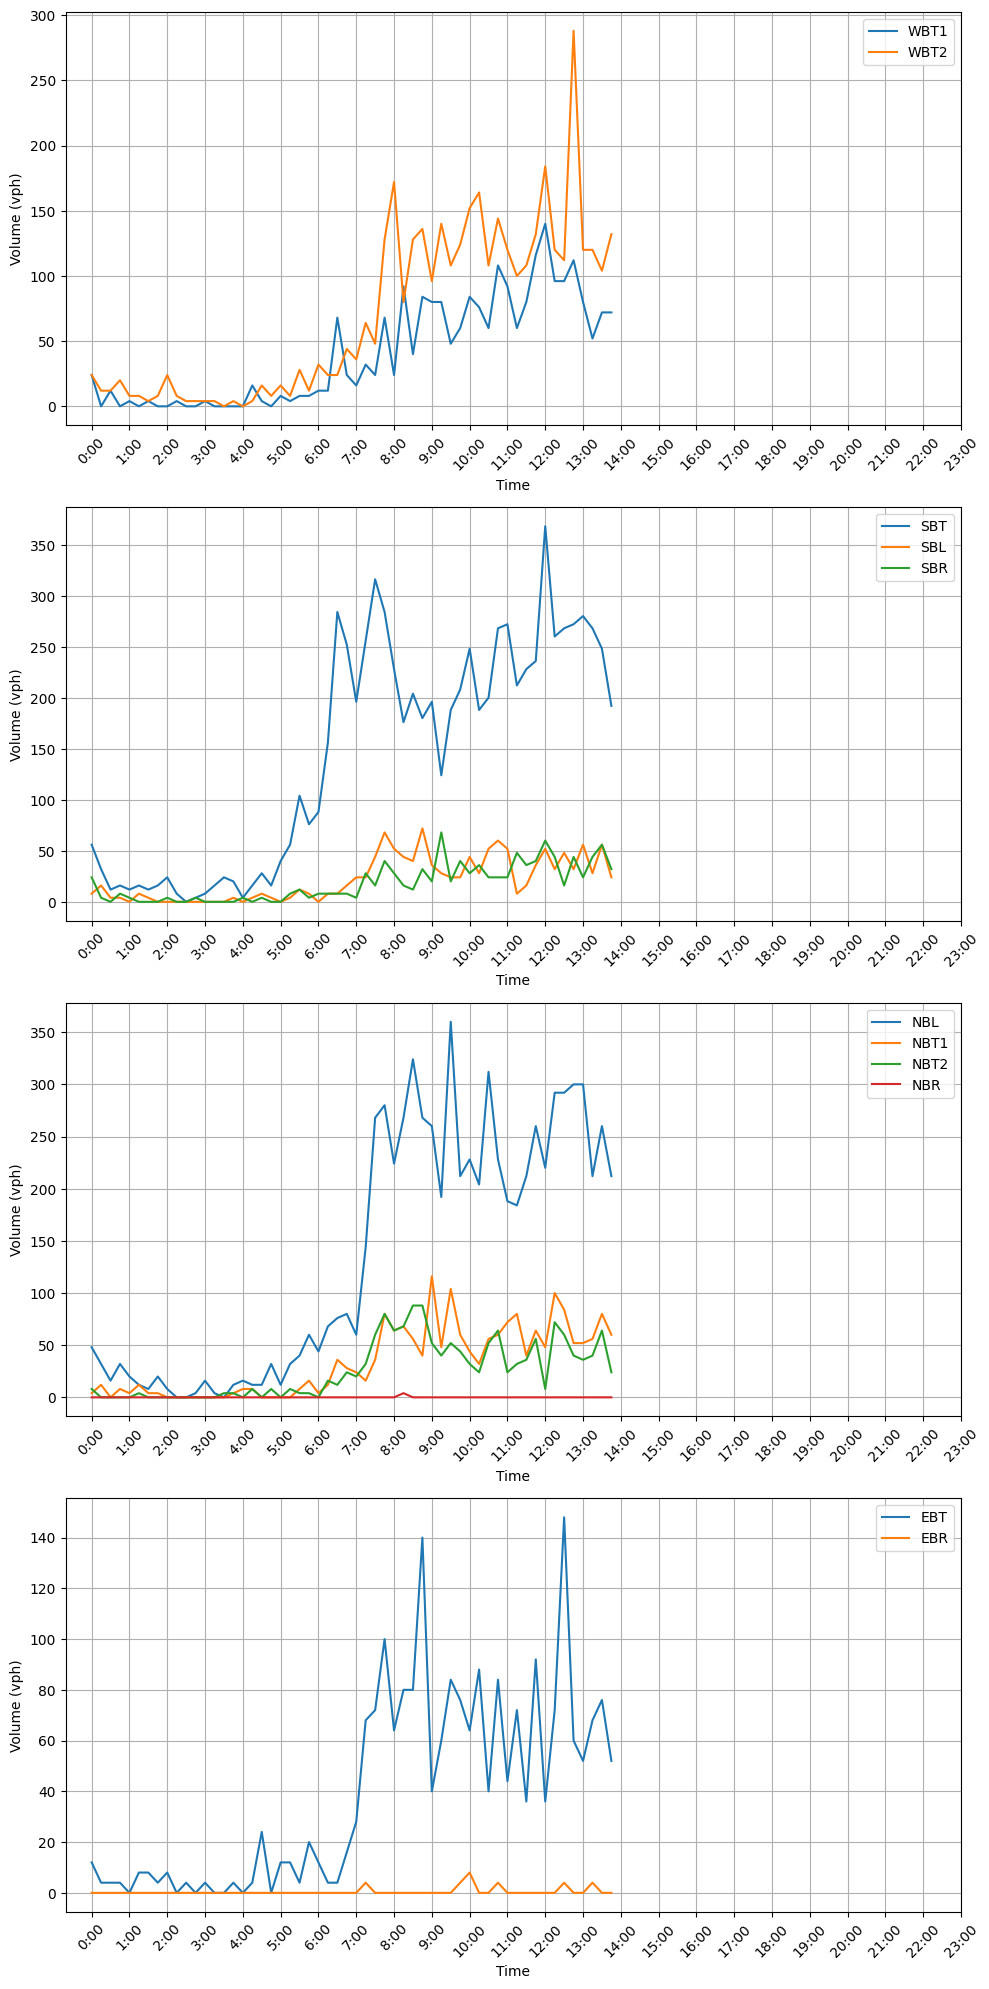

In [18]:
volumes = []
for lane_ind in tqdm(range(11)):
    test_total_records = pd.concat(total_res_files[lane_ind]).reset_index(drop = True)
    #  Unnamed: 0 is timestamp
    #  queue_length is queue length
    #  volume is volume
    test_total_records.loc[:,'Unnamed: 0'] = pd.to_datetime(test_total_records.loc[:,'Unnamed: 0'])
    test_total_records.columns = ['timestamp','queue_length','volume']
    # sort the test_total_records by timestamp
    test_total_records = test_total_records.sort_values('timestamp').reset_index(drop = True)
    test_total_records['timestamp'] = pd.to_datetime(test_total_records['timestamp']).dt.tz_localize(None)
    start_date = datetime.strptime('2024-03-20', '%Y-%m-%d')
    end_date = datetime.strptime('2024-03-21', '%Y-%m-%d')
    selected_records = test_total_records[(test_total_records['timestamp'] > start_date) & (test_total_records['timestamp'] < end_date)]
    # calculate volume at each 15 minutes
    volume_15_min = []
    for i in range(0,len(selected_records),15*60):
        volume_15_min.append(selected_records['volume'][i:i+15*60].sum())
    volumes.append(volume_15_min)
# 3/18/2024 is Monday
movement_names = ['WBT1','WBT2','SBT','SBL','SBR','NBL','NBT1','NBT2','NBR','EBT','EBR']
# Create a figure with subplots
fig, axs = plt.subplots(4, 1, figsize=(10, 20))  # 4 rows, 1 column, each subplot with size 10x5
# add grid for each subplot
for ax in axs:
    ax.grid()
# Plot for the first group
axs[0].plot(np.array(volumes[0])*4, label=movement_names[0])
axs[0].plot(np.array(volumes[1])*4, label=movement_names[1])
axs[0].set_xticks(np.arange(0, 96, 4))
axs[0].set_xticklabels([f'{i}:00' for i in range(24)], rotation=45)
axs[0].legend()
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Volume (vph)')

# Plot for the second group (SB)
axs[1].plot(np.array(volumes[2])*4, label=movement_names[2])
axs[1].plot(np.array(volumes[3])*4, label=movement_names[3])
axs[1].plot(np.array(volumes[4])*4, label=movement_names[4])
axs[1].set_xticks(np.arange(0, 96, 4))
axs[1].set_xticklabels([f'{i}:00' for i in range(24)], rotation=45)
axs[1].legend()
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Volume (vph)')

# Plot for the third group (NB)
axs[2].plot(np.array(volumes[5])*4, label=movement_names[5])
axs[2].plot(np.array(volumes[6])*4, label=movement_names[6])
axs[2].plot(np.array(volumes[7])*4, label=movement_names[7])
axs[2].plot(np.array(volumes[8])*4, label=movement_names[8])
axs[2].set_xticks(np.arange(0, 96, 4))
axs[2].set_xticklabels([f'{i}:00' for i in range(24)], rotation=45)
axs[2].legend()
axs[2].set_xlabel('Time')
axs[2].set_ylabel('Volume (vph)')

# Plot for the fourth group (EB)
axs[3].plot(np.array(volumes[9])*4, label=movement_names[9])
axs[3].plot(np.array(volumes[10])*4, label=movement_names[10])
axs[3].set_xticks(np.arange(0, 96, 4))
axs[3].set_xticklabels([f'{i}:00' for i in range(24)], rotation=45)
axs[3].legend()
axs[3].set_xlabel('Time')
axs[3].set_ylabel('Volume (vph)')

plt.tight_layout()  # Adjust layout to prevent overlap
plt.savefig('/home/czh/Documents/QueueClassPre/volume_320.png',dpi = 300)
plt.show()



In [12]:
queues = []
for lane_ind in tqdm(range(11)):
    test_total_records = pd.concat(total_res_files[lane_ind]).reset_index(drop = True)
    #  Unnamed: 0 is timestamp
    #  queue_length is queue length
    #  volume is volume
    test_total_records.loc[:,'Unnamed: 0'] = pd.to_datetime(test_total_records.loc[:,'Unnamed: 0'])
    test_total_records.columns = ['timestamp','queue_length','volume']
    # sort the test_total_records by timestamp
    test_total_records = test_total_records.sort_values('timestamp').reset_index(drop = True)
    test_total_records['timestamp'] = pd.to_datetime(test_total_records['timestamp']).dt.tz_localize(None)
    start_date = datetime.strptime('2024-03-15', '%Y-%m-%d')
    end_date = datetime.strptime('2024-03-16', '%Y-%m-%d')
    selected_records = test_total_records[(test_total_records['timestamp'] > start_date) & (test_total_records['timestamp'] < end_date)]
    # calculate volume at each 15 minutes
    queue_15min = []
    for i in range(0,len(selected_records),15*60):
        # calculate volume at each 15 minutes
        queue_15min.append(selected_records['queue_length'][i:i+15*60].mean())
    queues.append(queue_15min)

100%|██████████| 11/11 [00:35<00:00,  3.18s/it]


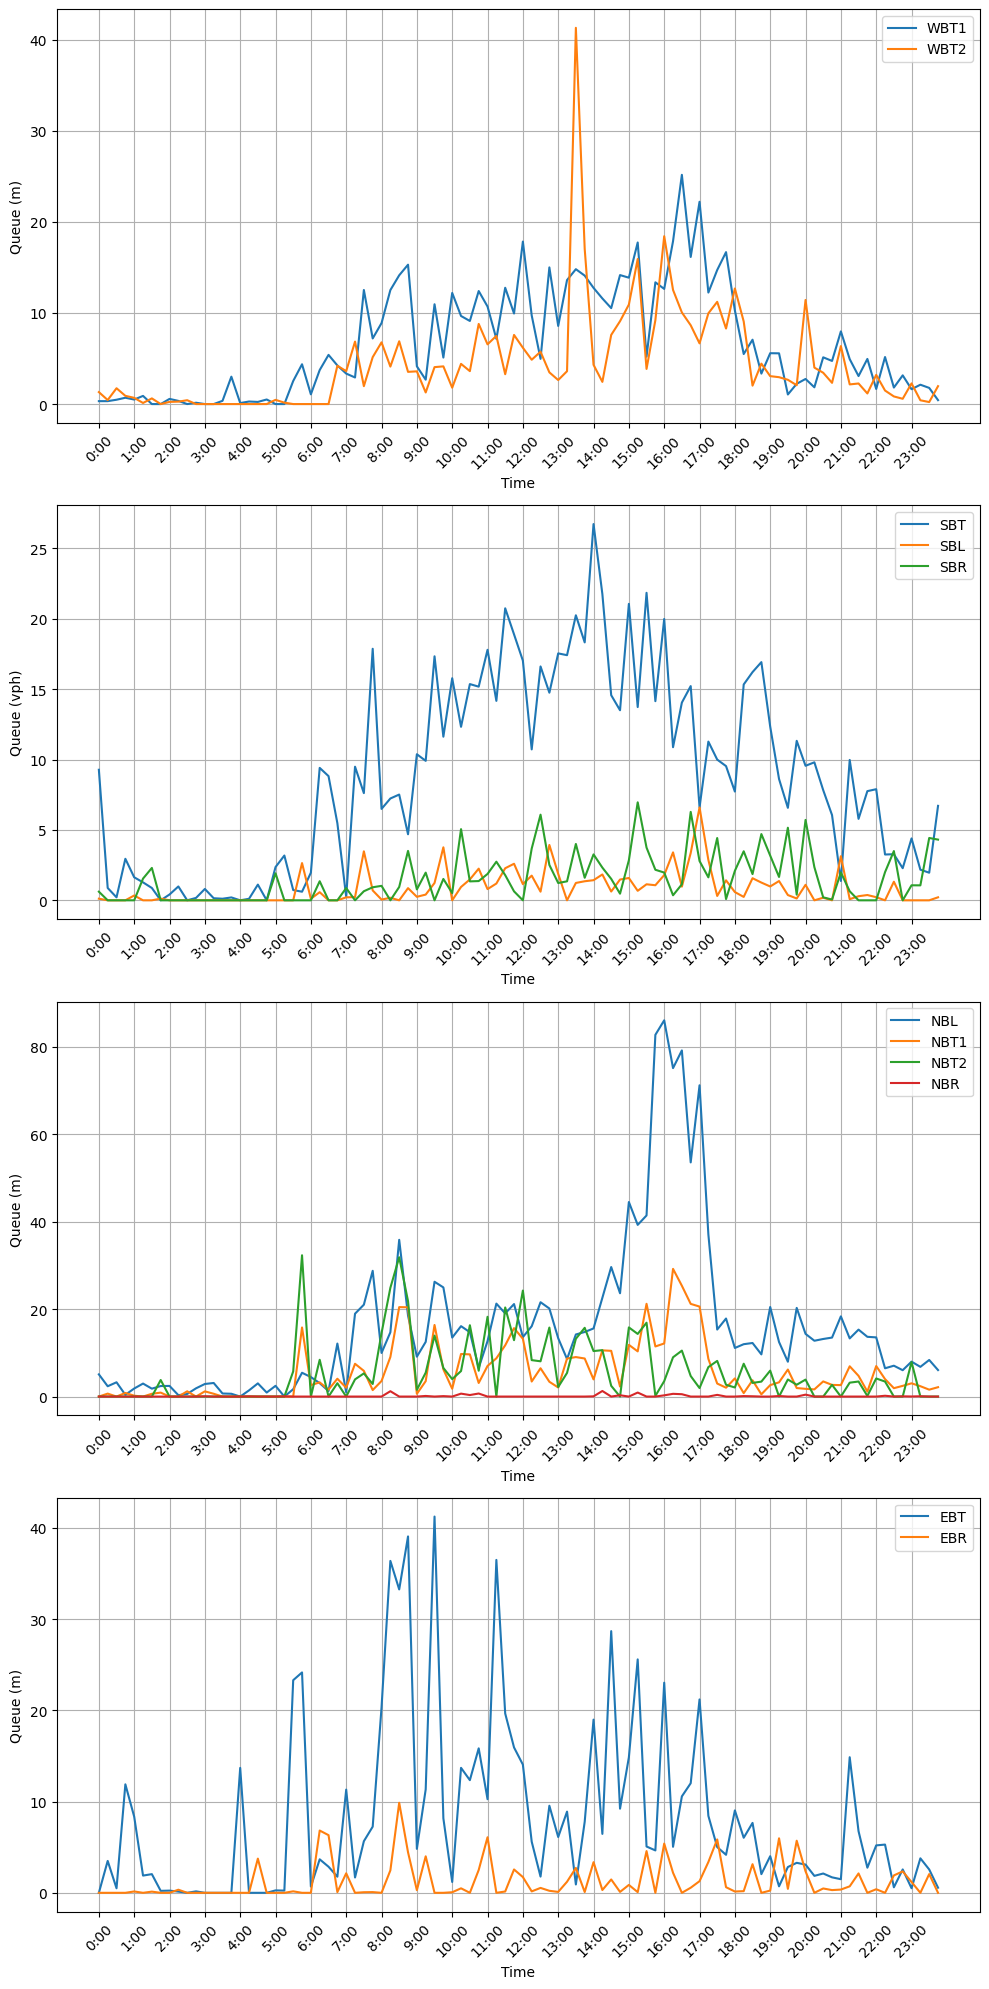

In [13]:
movement_names = ['WBT1','WBT2','SBT','SBL','SBR','NBL','NBT1','NBT2','NBR','EBT','EBR']
# Create a figure with subplots
fig, axs = plt.subplots(4, 1, figsize=(10, 20))  # 4 rows, 1 column, each subplot with size 10x5
# add grid for each subplot
for ax in axs:
    ax.grid()
# Plot for the first group
axs[0].plot(np.array(queues[0])*4, label=movement_names[0])
axs[0].plot(np.array(queues[1])*4, label=movement_names[1])
axs[0].set_xticks(np.arange(0, 96, 4))
axs[0].set_xticklabels([f'{i}:00' for i in range(24)], rotation=45)
axs[0].legend()
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Queue (m)')

# Plot for the second group (SB)
axs[1].plot(np.array(queues[2])*4, label=movement_names[2])
axs[1].plot(np.array(queues[3])*4, label=movement_names[3])
axs[1].plot(np.array(queues[4])*4, label=movement_names[4])
axs[1].set_xticks(np.arange(0, 96, 4))
axs[1].set_xticklabels([f'{i}:00' for i in range(24)], rotation=45)
axs[1].legend()
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Queue (vph)')

# Plot for the third group (NB)
axs[2].plot(np.array(queues[5])*4, label=movement_names[5])
axs[2].plot(np.array(queues[6])*4, label=movement_names[6])
axs[2].plot(np.array(queues[7])*4, label=movement_names[7])
axs[2].plot(np.array(queues[8])*4, label=movement_names[8])
axs[2].set_xticks(np.arange(0, 96, 4))
axs[2].set_xticklabels([f'{i}:00' for i in range(24)], rotation=45)
axs[2].legend()
axs[2].set_xlabel('Time')
axs[2].set_ylabel('Queue (m)')

# Plot for the fourth group (EB)
axs[3].plot(np.array(queues[9])*4, label=movement_names[9])
axs[3].plot(np.array(queues[10])*4, label=movement_names[10])
axs[3].set_xticks(np.arange(0, 96, 4))
axs[3].set_xticklabels([f'{i}:00' for i in range(24)], rotation=45)
axs[3].legend()
axs[3].set_xlabel('Time')
axs[3].set_ylabel('Queue (m)')

plt.tight_layout()  # Adjust layout to prevent overlap
# plt.savefig('/home/czh/Documents/QueueClassPre/queue_320.png',dpi = 300)
plt.show()

100%|██████████| 11/11 [00:33<00:00,  3.05s/it]


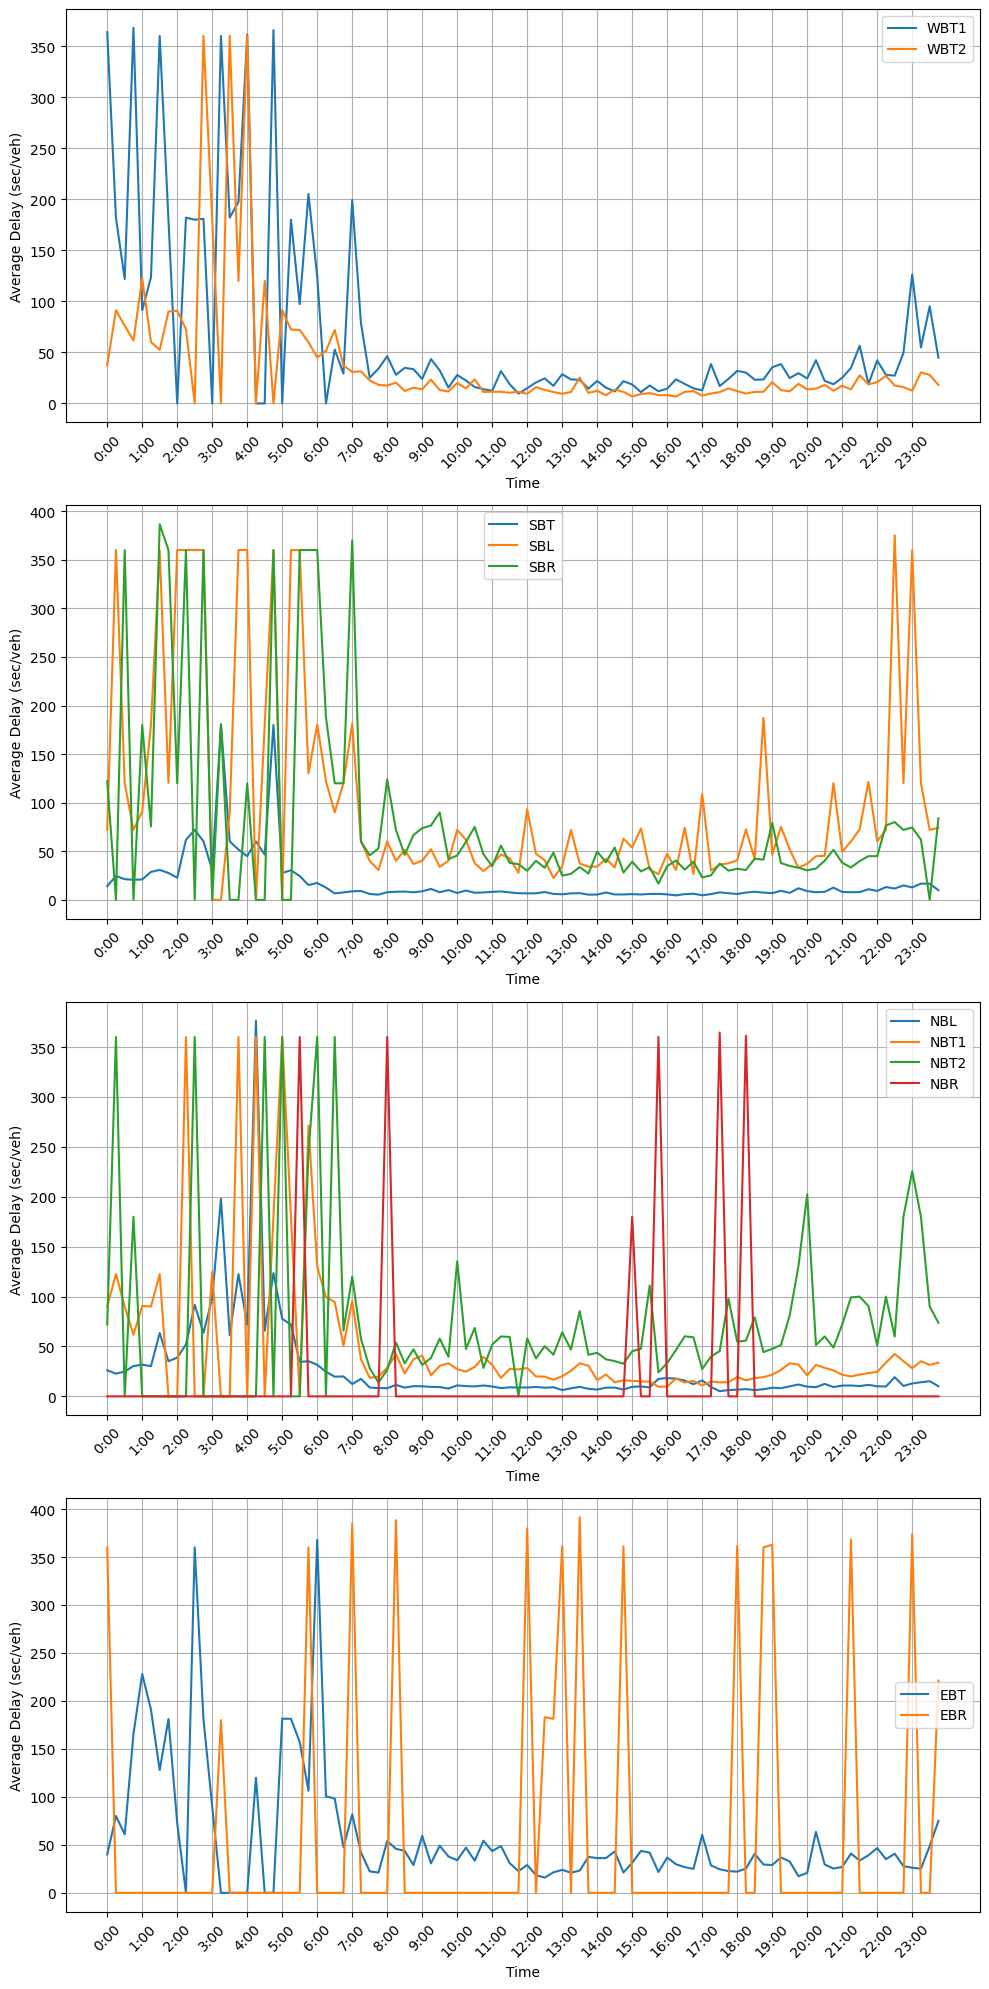

In [9]:
delays = []
for lane_ind in tqdm(range(11)):
    test_total_records = pd.concat(total_res_files[lane_ind]).reset_index(drop = True)
    #  Unnamed: 0 is timestamp
    #  queue_length is queue length
    #  volume is volume
    test_total_records.loc[:,'Unnamed: 0'] = pd.to_datetime(test_total_records.loc[:,'Unnamed: 0'])
    test_total_records.columns = ['timestamp','queue_length','volume']
    # sort the test_total_records by timestamp
    test_total_records = test_total_records.sort_values('timestamp').reset_index(drop = True)
    test_total_records['timestamp'] = pd.to_datetime(test_total_records['timestamp']).dt.tz_localize(None)
    start_date = datetime.strptime('2024-03-15', '%Y-%m-%d')
    end_date = datetime.strptime('2024-03-16', '%Y-%m-%d')
    selected_records = test_total_records[(test_total_records['timestamp'] > start_date) & (test_total_records['timestamp'] < end_date)]
    # get each 15 minutes delay
    delay_15min = []
    for i in range(0,len(selected_records),15*60):
        # calculate volume at each 15 minutes
        volume_15 = selected_records['volume'][i:i+15*60].sum()
        if volume_15 ==  0:
            delay_15min.append(0)
            continue
        total_queue_num_15 = ((selected_records['queue_length'][i:i+15*60] / (4.8 + 3) + 1) * 0.1).sum() 
        average_delay = total_queue_num_15/volume_15
        if average_delay > 100:
            delay_15min.append(0)
            continue
        delay_15min.append(average_delay)
    delays.append(delay_15min)

movement_names = ['WBT1','WBT2','SBT','SBL','SBR','NBL','NBT1','NBT2','NBR','EBT','EBR']
# Create a figure with subplots
fig, axs = plt.subplots(4, 1, figsize=(10, 20))  # 4 rows, 1 column, each subplot with size 10x5
# add grid for each subplot
for ax in axs:
    ax.grid()
# Plot for the first group
axs[0].plot(np.array(delays[0])*4, label=movement_names[0])
axs[0].plot(np.array(delays[1])*4, label=movement_names[1])
axs[0].set_xticks(np.arange(0, 96, 4))
axs[0].set_xticklabels([f'{i}:00' for i in range(24)], rotation=45)
axs[0].legend()
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Average Delay (sec/veh)')

# Plot for the second group (SB)
axs[1].plot(np.array(delays[2])*4, label=movement_names[2])
axs[1].plot(np.array(delays[3])*4, label=movement_names[3])
axs[1].plot(np.array(delays[4])*4, label=movement_names[4])
axs[1].set_xticks(np.arange(0, 96, 4))
axs[1].set_xticklabels([f'{i}:00' for i in range(24)], rotation=45)
axs[1].legend()
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Average Delay (sec/veh)')

# Plot for the third group (NB)
axs[2].plot(np.array(delays[5])*4, label=movement_names[5])
axs[2].plot(np.array(delays[6])*4, label=movement_names[6])
axs[2].plot(np.array(delays[7])*4, label=movement_names[7])
axs[2].plot(np.array(delays[8])*4, label=movement_names[8])
axs[2].set_xticks(np.arange(0, 96, 4))
axs[2].set_xticklabels([f'{i}:00' for i in range(24)], rotation=45)
axs[2].legend()
axs[2].set_xlabel('Time')
axs[2].set_ylabel('Average Delay (sec/veh)')

# Plot for the fourth group (EB)
axs[3].plot(np.array(delays[9])*4, label=movement_names[9])
axs[3].plot(np.array(delays[10])*4, label=movement_names[10])
axs[3].set_xticks(np.arange(0, 96, 4))
axs[3].set_xticklabels([f'{i}:00' for i in range(24)], rotation=45)
axs[3].legend()
axs[3].set_xlabel('Time')
axs[3].set_ylabel('Average Delay (sec/veh)')

plt.tight_layout()  # Adjust layout to prevent overlap
# plt.savefig('/home/czh/Documents/QueueClassPre/queue_320.png',dpi = 300)
plt.show()

In [ ]:
movement_names = ['WBT1','WBT2','SBT','SBL','SBR','NBL','NBT1','NBT2','NBR','EBT','EBR']
# Create a figure with subplots
fig, axs = plt.subplots(4, 1, figsize=(10, 20))  # 4 rows, 1 column, each subplot with size 10x5
# add grid for each subplot
for ax in axs:
    ax.grid()
# Plot for the first group
axs[0].plot(np.array(delays[0])*4, label=movement_names[0])
axs[0].plot(np.array(delays[1])*4, label=movement_names[1])
axs[0].set_xticks(np.arange(0, 96, 4))
axs[0].set_xticklabels([f'{i}:00' for i in range(24)], rotation=45)
axs[0].legend()
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Average Delay (sec/veh)')

# Plot for the second group (SB)
axs[1].plot(np.array(delays[2])*4, label=movement_names[2])
axs[1].plot(np.array(delays[3])*4, label=movement_names[3])
axs[1].plot(np.array(delays[4])*4, label=movement_names[4])
axs[1].set_xticks(np.arange(0, 96, 4))
axs[1].set_xticklabels([f'{i}:00' for i in range(24)], rotation=45)
axs[1].legend()
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Average Delay (sec/veh)')

# Plot for the third group (NB)
axs[2].plot(np.array(delays[5])*4, label=movement_names[5])
axs[2].plot(np.array(delays[6])*4, label=movement_names[6])
axs[2].plot(np.array(delays[7])*4, label=movement_names[7])
axs[2].plot(np.array(delays[8])*4, label=movement_names[8])
axs[2].set_xticks(np.arange(0, 96, 4))
axs[2].set_xticklabels([f'{i}:00' for i in range(24)], rotation=45)
axs[2].legend()
axs[2].set_xlabel('Time')
axs[2].set_ylabel('Average Delay (sec/veh)')

# Plot for the fourth group (EB)
axs[3].plot(np.array(delays[9])*4, label=movement_names[9])
axs[3].plot(np.array(delays[10])*4, label=movement_names[10])
axs[3].set_xticks(np.arange(0, 96, 4))
axs[3].set_xticklabels([f'{i}:00' for i in range(24)], rotation=45)
axs[3].legend()
axs[3].set_xlabel('Time')
axs[3].set_ylabel('Average Delay (sec/veh)')

plt.tight_layout()  # Adjust layout to prevent overlap
# plt.savefig('/home/czh/Documents/QueueClassPre/queue_320.png',dpi = 300)
plt.show()